In [436]:
from urllib.request import urlopen
import folium
import folium.plugins
from geopy.geocoders import Nominatim

In [23]:
# pip install beautifulsoup4
from bs4 import BeautifulSoup

Note: you may need to restart the kernel to use updated packages.


In [174]:
url = 'https://www.sportscheck.com/filialen/'
url

'https://www.sportscheck.com/filialen/'

In [525]:
def get_dict_branches(url:str, selected_row:int, logging:bool= False) -> dict:
    page = urlopen(url)
    html = page.read().decode("utf-8")
    soup = BeautifulSoup(html, 'html.parser')
    print(soup.find('h2').get_text())

    className = 'landingpage-text__inner landingpage-text--centered'
    results = soup.find_all('div', {'class': className})

    tag = results[selected_row]
    l_branches = tag.find_all('a')

    l_links = [branch.get('href') for branch in l_branches]
    l_cities = [branch.text for branch in l_branches]
    
    if logging: # l_links
        print(f'length l_links={len(l_links)}')
        print(f'length l_cities={len(l_cities)}')

    output = {}
    for key, value in zip(l_links, l_cities):
        output.setdefault(key, []).append(value)
    
    if logging:
        print(output)
    return output

In [690]:
url = 'https://www.sportscheck.com/filialen/'
output = get_dict_branches(url,1)
print(len(output))
output

SPORTSCHECK FILIALEN 
30


{'https://www.sportscheck.com/filialen/aachen/': ['Aachen'],
 'https://www.sportscheck.com/filialen/berlin-schoeneberg/': ['Berlin-Schöneberg',
  ''],
 'https://www.sportscheck.com/filialen/berlin-steglitz/': ['Berlin-Steglitz'],
 'https://www.sportscheck.com/filialen/bielefeld/': ['Bielefeld', '', ''],
 'https://www.sportscheck.com/filialen/bonn/': ['Bonn'],
 'https://www.sportscheck.com/filialen/braunschweig/': ['Braunschweig'],
 'https://www.sportscheck.com/filialen/bremen/': [''],
 'https://www.sportscheck.com/filialen/dortmund/': ['Dortmund'],
 'https://www.sportscheck.com/filialen/dresden-centrum-galerie/': ['',
  'Dresden Centrum-Galerie'],
 'https://www.sportscheck.com/filialen/dresden-altmarkt-galerie/': ['Dresden\xa0Altmarkt-Galerie',
  '',
  ''],
 'https://www.sportscheck.com/filialen/erfurt/': ['Erfurt'],
 'https://www.sportscheck.com/filialen/frankfurt/': ['Frankfurt', ''],
 'https://www.sportscheck.com/filialen/goettingen/': ['Göttingen'],
 'https://www.sportscheck.com/fi

In [691]:
def find_index(lis:list, substring:str):
    indices = [i for i, element in enumerate(lis) if substring in element.lower()]
    if indices:
        # print(f"Found '{substring}' at indices {indices}")
        return indices[0]
    else:
        # print(f"'{substring}' not found in the list")
        return -1

def get_info_branch(it:int, branch_url:str, location_city:str, selected_row:int, logging:bool= False) :
    page = urlopen(branch_url)
    html = page.read().decode("utf-8")
    soup = BeautifulSoup(html, 'html.parser')
    if logging:
        print(soup.find('h2').get_text())
    
    className = 'landingpage-text__inner landingpage-text--centered'
    results = soup.find_all('div', {'class': className})
    # print(type(results))
    tag = results[selected_row]
    # print(type(tag))
    if logging:
        print(tag.text)
    s2=tag.text.split('\n')
    s2.remove('\xa0')

    # print(f's2={s2}')
    
    idx_start = find_index(s2,'sportscheck')
    end_row = find_index(s2,'mail')

    if idx_start==-1:
        print(f'Invalid start_row={idx_start}')
        return None,None,None
    if end_row == -1:
        print(f'Invalid end_row={start_row}')
        return [None,None,None]

    start_row = idx_start + 1
    address = " ".join(s2[start_row:end_row])
        
    sub_str = ['shopping','center','mall','plaza']
    if any(x in s2[start_row].lower() for x in sub_str):
        print(f'Found mall={s2[start_row]}')
        start_row = start_row + 1
        
    
    # print(f'start_row:{start_row}')
    # print(f'end_row:{end_row}')
        
    address = " ".join(s2[start_row:end_row])
    
    if 'sss' in address:
        address = address.replace("sss", "ss")
        print(f'sss={s2[start_row]}')
    print(f'address={address}')
    
    locator = Nominatim(user_agent="google") # https://github.com/geopy/geopy/tree/master/geopy/geocoders
    location_with_address = locator.geocode(address)
    print(f'  1.location_with_address={location_with_address}')
    
    # print(f'location:{location}')

    location_with_osm = None
    for elem in location_city:
        if elem:
            print(f'elem={elem}')
            osm_address = f'SportScheck {elem}'
            location_with_osm = locator.geocode(osm_address)
            if location_with_osm is not None:
                print(f'location_with_osm={location_with_osm}')
                print(f'Found directly the SportScheck in {elem}')
                continue

    if location_with_address is None:
        print(f'location_with_address invalid={address}')
        location = location_with_osm
    else:
        location = location_with_address

    if location is None:
        print('No Location whatsoever')
        return [None,None,None]
    
    print(f'url={url}')
    print(f'location={location}')
    
    link = f'''<a href={branch_url}>{branch_url}</a>'''

    l_fg_address = folium.FeatureGroup(name=f'[#{it}] SportScheck {location_city}/Address')    
    if location_with_address is not None:
        print(f'  3.location_with_address={location_with_address}')
        points = [[location_with_address.raw['boundingbox'][0],location_with_address.raw['boundingbox'][2]],[location_with_address.raw['boundingbox'][1],location_with_address.raw['boundingbox'][3]]]
        rect = folium.Rectangle(bounds=points, color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2, 
                                tooltip=location_with_address.address,
                                popup=link)
        l_fg_address.add_child(rect)

    
    l_fg_osm = folium.FeatureGroup(name=f'[#{it}] SportScheck {location_city}/OSM')
    if location_with_osm is not None:
        print(f'  2.location_with_osm={location_with_osm}')
        points = [[location_with_osm.raw['boundingbox'][0],location_with_osm.raw['boundingbox'][2]],[location_with_osm.raw['boundingbox'][1],location_with_osm.raw['boundingbox'][3]]]
        rect_with_city = folium.Rectangle(bounds=points, color='blue', fill=True, fill_color='#ffff00', fill_opacity=0.2, 
                        tooltip=location_with_osm.address,
                        popup=link)
        l_fg_osm.add_child(rect_with_city)
        
    
    l_fg_marker = folium.FeatureGroup(name=f'[#{it}] SportScheck {location_city}/Marker')
    marker = folium.Marker(location=[location.raw['lat'], location.raw["lon"]],
                              tooltip=location.address,
                              popup=link,
                              icon=folium.features.CustomIcon(icon_image='logo.png',
                                                              icon_size=(50, 15)
                                                             )
                              )
    l_fg_marker.add_child(marker)

    return [l_fg_osm,l_fg_address,l_fg_marker]

In [688]:
output = {
'https://www.sportscheck.com/filialen/hamburg-altstadt/': ['Hamburg-Altstadt', '']
#     # 'https://www.sportscheck.com/filialen/koeln/': ['Köln'],
#     # 'https://www.sportscheck.com/filialen/moenchengladbach/': ['Mönchengladbach'],
# #  'https://www.sportscheck.com/filialen/muenchen/': [''],
# #  'https://www.sportscheck.com/filialen/muenster/': ['Münster'],
# #  'https://www.sportscheck.com/filialen/nuernberg/': ['Nürnberg'],
#  'https://www.sportscheck.com/filialen/stuttgart/': ['Stuttgart', ''],
# #  'https://www.sportscheck.com/filialen/wildau/': ['Wildau']
}

i=0/29, key=https://www.sportscheck.com/filialen/aachen/, value=['Aachen']
Found mall=Aquis Plaza
address=Adalbertstraße 100 52062 Aachen
  1.location_with_address=Aquis Plaza, 100, Adalbertstraße, Kaiserplatz, Burtscheid, Aachen-Mitte, Aachen, Städteregion Aachen, Nordrhein-Westfalen, 52062, Deutschland
elem=Aachen
url=https://www.sportscheck.com/filialen/
location=Aquis Plaza, 100, Adalbertstraße, Kaiserplatz, Burtscheid, Aachen-Mitte, Aachen, Städteregion Aachen, Nordrhein-Westfalen, 52062, Deutschland
  3.location_with_address=Aquis Plaza, 100, Adalbertstraße, Kaiserplatz, Burtscheid, Aachen-Mitte, Aachen, Städteregion Aachen, Nordrhein-Westfalen, 52062, Deutschland

i=1/29, key=https://www.sportscheck.com/filialen/berlin-schoeneberg/, value=['Berlin-Schöneberg', '']
address=Tauentzienstraße 5  10789 Berlin
  1.location_with_address=Dörfer Kieferorthopädie, 5, Tauentzienstraße, Schöneberg, Tempelhof-Schöneberg, Berlin, 10789, Deutschland
elem=Berlin-Schöneberg
url=https://www.sport


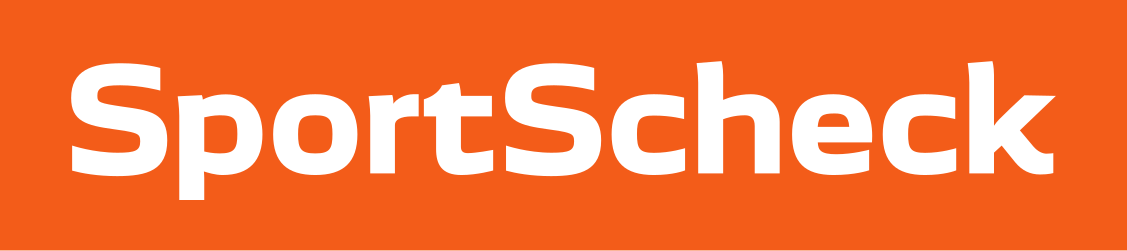
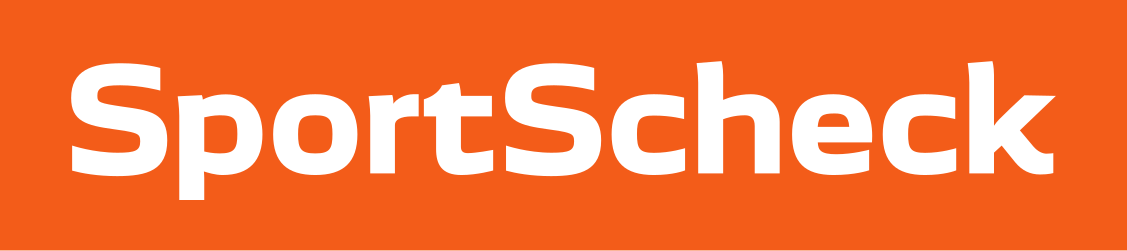
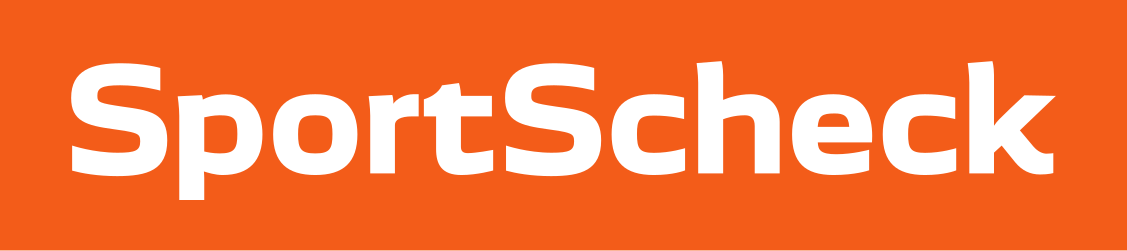
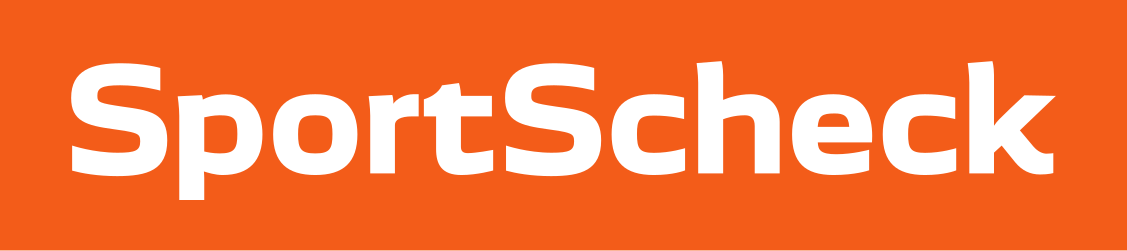
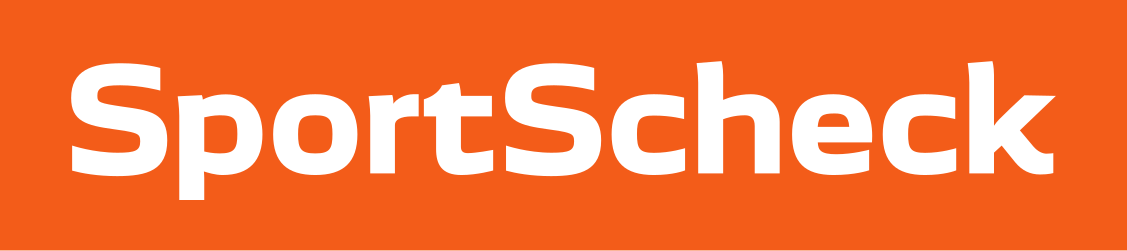
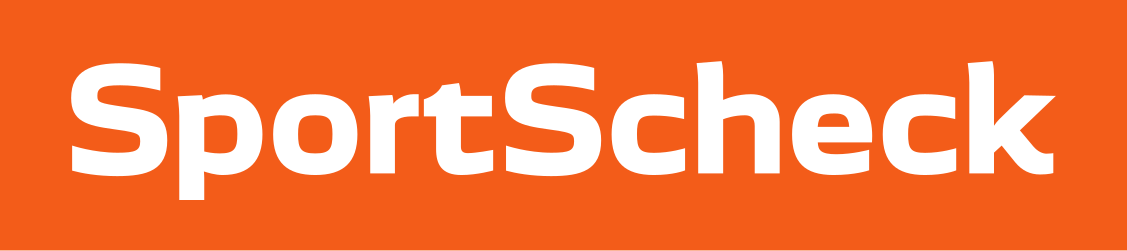
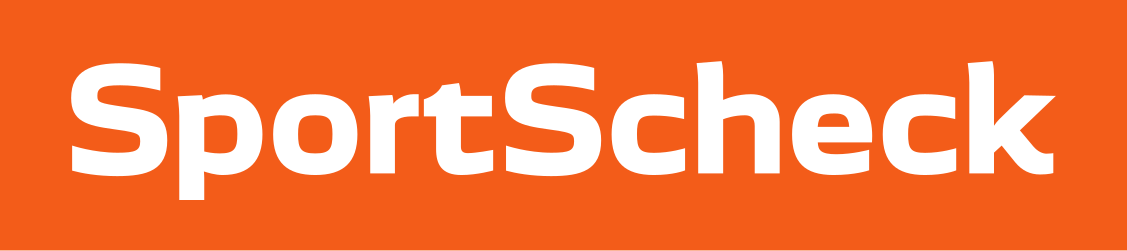
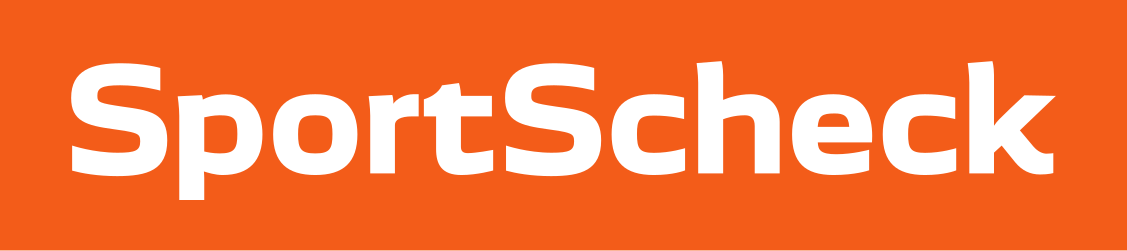
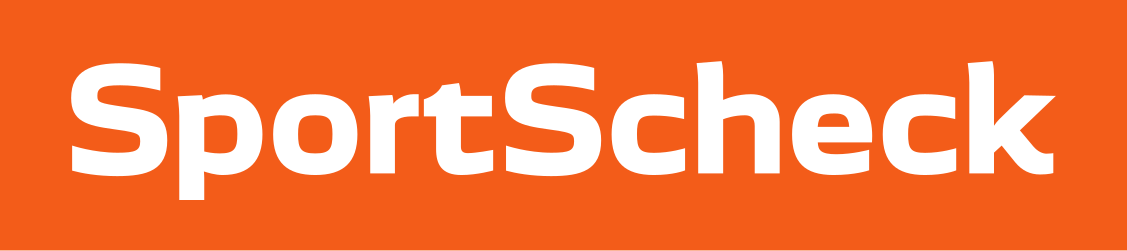
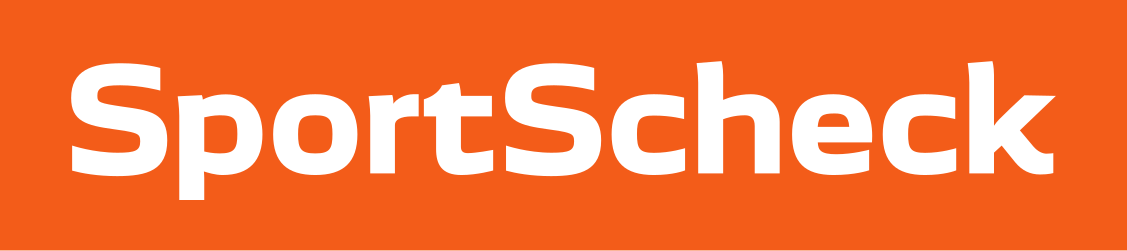
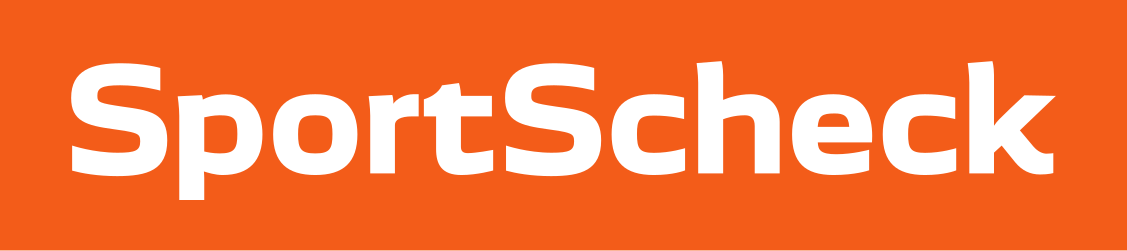
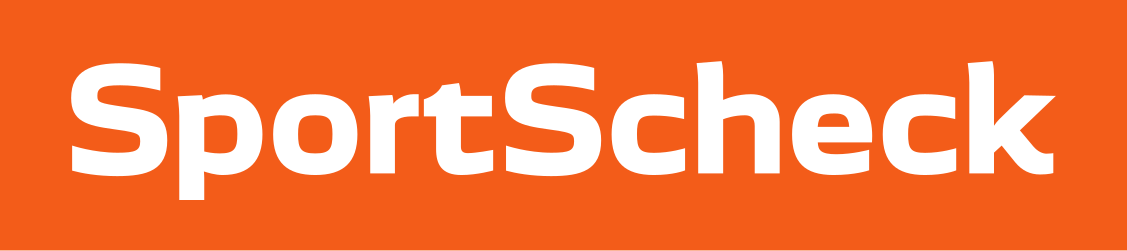
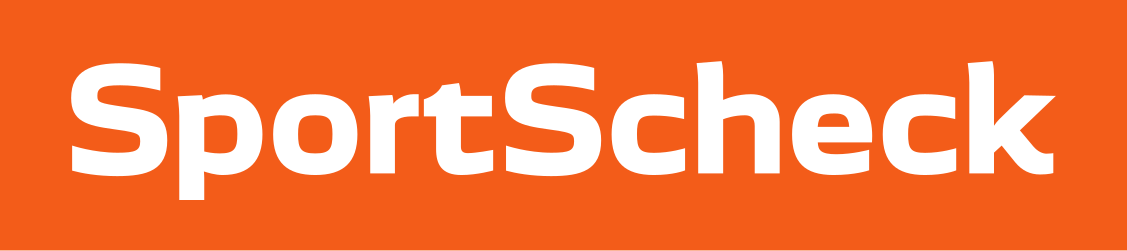
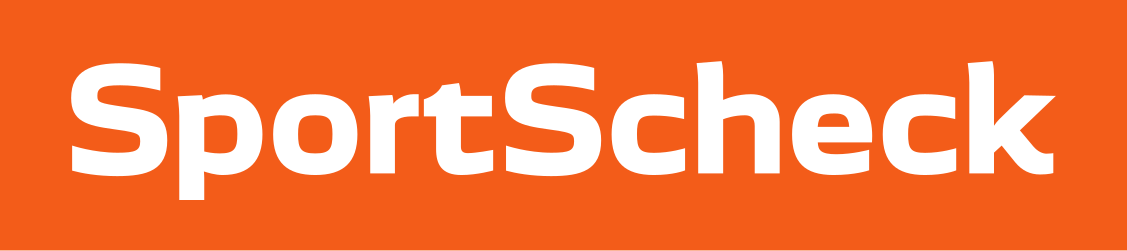
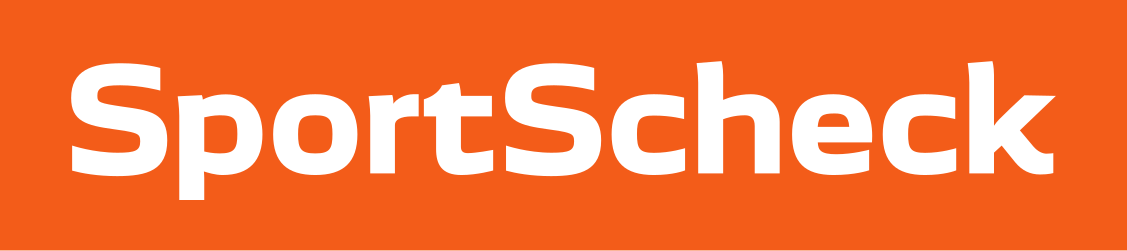
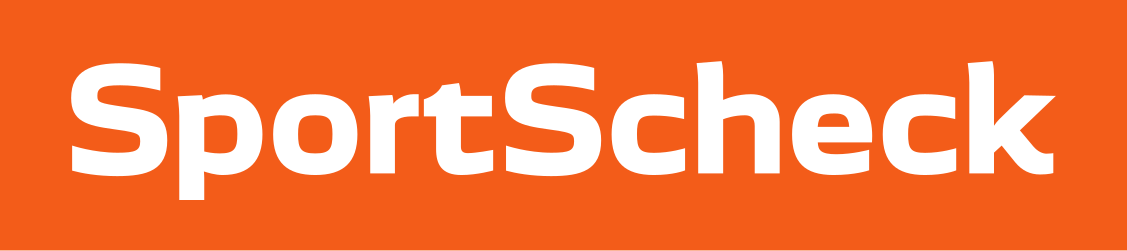
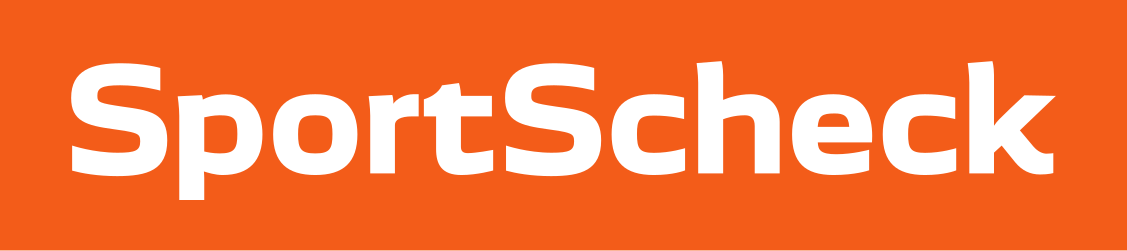
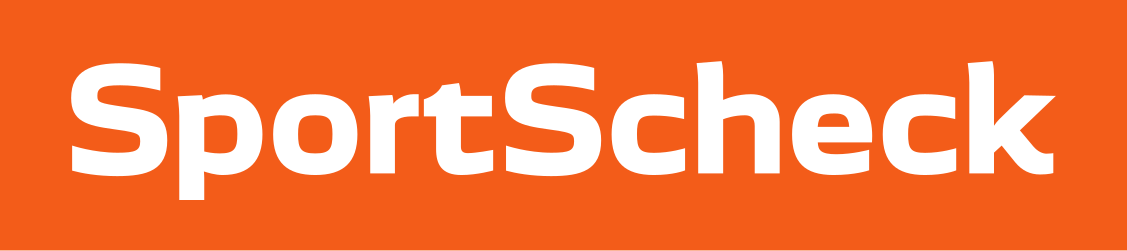
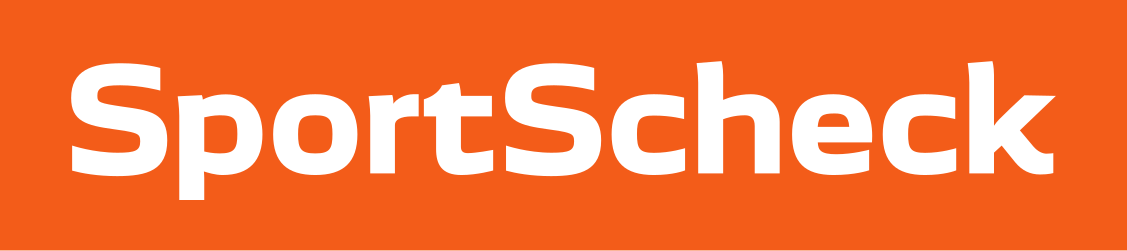
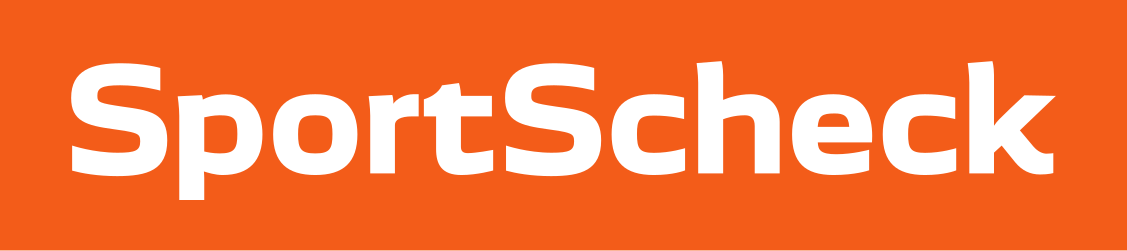
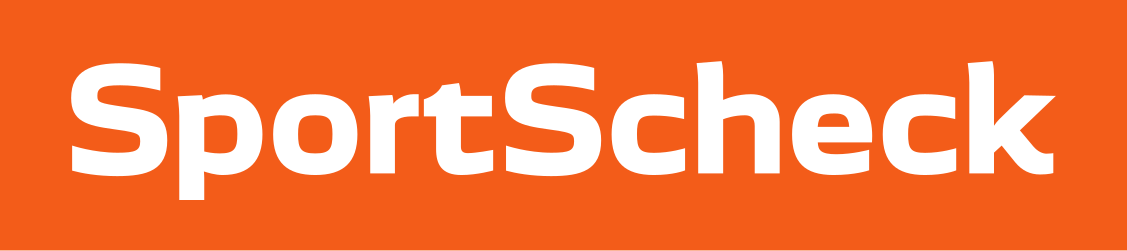
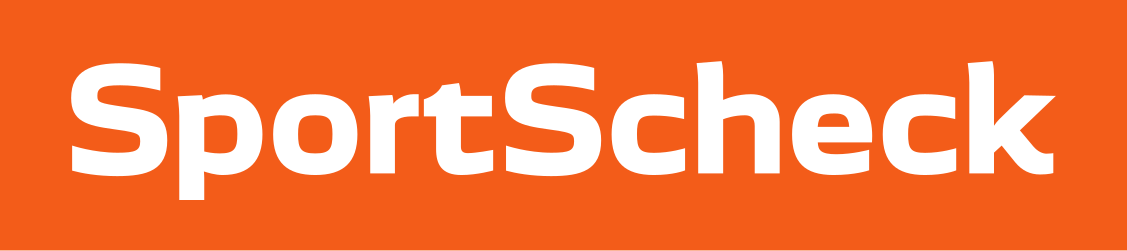
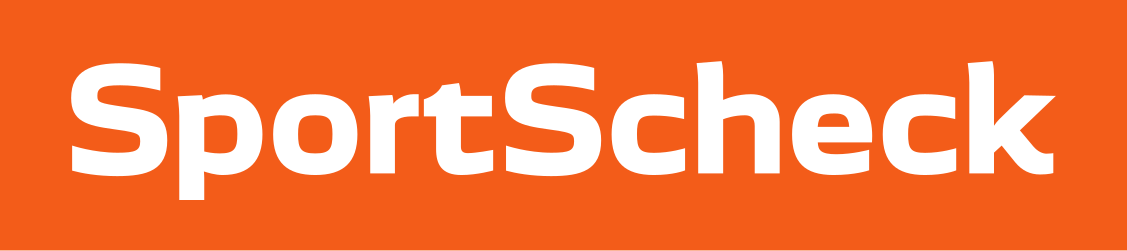
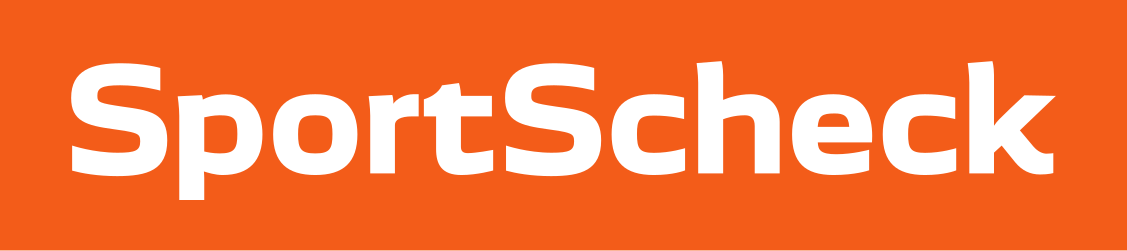
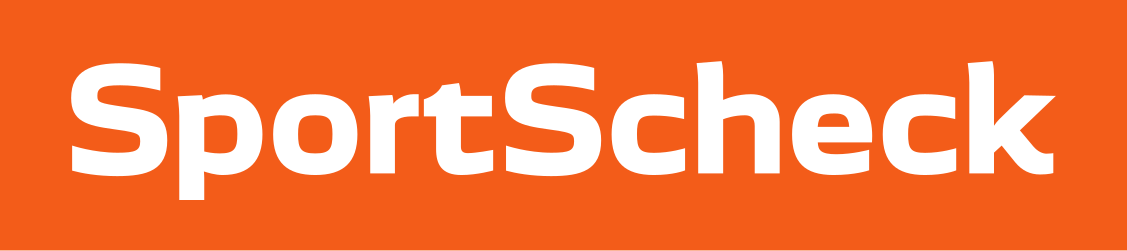

In [692]:
m=folium.Map()

for i,(key,value) in enumerate(output.items()):
    print(f'i={i}/{len(output)-1}, key={key}, value={value}')
    if '' in value and len(value)==1:
        print(f'The branch {key} has been removed or has moved')
    else:
        l_fg_osm,l_fg_address,l_fg_marker = get_info_branch(i,key,value,1)
        if l_fg_marker is not None:
            l_fg_marker.add_to(m)
        if l_fg_osm is not None:
            l_fg_osm.add_to(m)
        if l_fg_address is not None:
            l_fg_address.add_to(m)
    print()

fullscreen = folium.plugins.Fullscreen(position='topleft',
                                           title='Expand me',
                                           title_cancel='Exit me',
                                           force_separate_button=True)
m.add_child(fullscreen)
layercontrol = folium.LayerControl(position='topright',
                                       collapsed=False)
fm = m.add_child(layercontrol)
fm.fit_bounds(fm.get_bounds())
fm

In [346]:
url2 = list(output.keys())[0]
print(f'url={url2}') 

rect = get_info_branch(url2,1)
map = folium.Map(max_zoom=18)
map.add_chil(rect)


url=https://www.sportscheck.com/filialen/aachen/
<class 'bs4.element.ResultSet'>
<class 'bs4.element.Tag'>


In [237]:
tag.find_all('p')

[<p>Montag - Freitag: 11:00 - 19:00 Uhr<br/>Samstag: 11:00 - 20:00 Uhr </p>,
 <p> </p>,
 <p>SportScheck Aachen</p>,
 <p>Aquis Plaza</p>,
 <p>Adalbertstraße 100</p>,
 <p>52062 Aachen</p>,
 <p>Mail: <span style="text-decoration: underline;">service@sportscheck.com</span></p>,
 <p> </p>,
 <p><span style="text-decoration: underline;"><a href="https://www.sportscheck.com/filialen/"><span style="font-family: Intro; font-size: 18.0pt;">zur Filialübersicht</span></a></span></p>]

In [239]:
print(tag.text)

ÖFFNUNGSZEITEN
Montag - Freitag: 11:00 - 19:00 UhrSamstag: 11:00 - 20:00 Uhr 
 
KONTAKT
SportScheck Aachen
Aquis Plaza
Adalbertstraße 100
52062 Aachen
Mail: service@sportscheck.com
 
zur Filialübersicht


In [337]:

s2

['ÖFFNUNGSZEITEN',
 'Montag - Freitag: 11:00 - 19:00 UhrSamstag: 11:00 - 20:00 Uhr\xa0',
 'KONTAKT',
 'SportScheck Aachen',
 'Aquis Plaza',
 'Adalbertstraße 100',
 '52062 Aachen',
 'Mail: service@sportscheck.com',
 '\xa0',
 'zur Filialübersicht']

In [341]:
" ".join(s2[4:7])

'Aquis Plaza Adalbertstraße 100 52062 Aachen'

In [276]:
locator = Nominatim(user_agent="google") # https://github.com/geopy/geopy/tree/master/geopy/geocoders
location = locator.geocode(f"{address} {city} {country}", language='English')
    # def geocode(
    #         self,
    #         query=None,
    #         *,
    #         exactly_one=True,
    #         timeout=DEFAULT_SENTINEL,
    #         bounds=None,
    #         region=None,
    #         components=None,
    #         place_id=None,
    #         language=None,
    #         sensor=False
    # ):
location
# print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

Location(Aquis Plaza, 100, Adalbertstraße, Kaiserplatz, Burtscheid, Aachen-Mitte, Aachen, Städteregion Aachen, Nordrhein-Westfalen, 52062, Deutschland, (50.77473085, 6.093145491143544, 0.0))

In [295]:
print(location.address)
# https://www.openstreetmap.org/way/31252157#map=18/50.774973/6.093217

Aquis Plaza, 100, Adalbertstraße, Kaiserplatz, Burtscheid, Aachen-Mitte, Aachen, Städteregion Aachen, Nordrhein-Westfalen, 52062, Deutschland


In [290]:
def print_members_accessible(location):
    return [i for i in dir(location) if not i[0].startswith('_')]
members = print_members_accessible(location)
members

['address', 'altitude', 'latitude', 'longitude', 'point', 'raw']

In [328]:
# pip install ogr

In [329]:
# pip install wget

In [297]:

location = locator.geocode(f"{address}, {city}, {country}")
location.raw

# NODES: Nodes are objects with a position (coordinates). Nodes can represent a postbox, tree, subway entrance, city center, building number, etc
# WAYS:  A way is a line or polygon, for example, for streets, rivers, buildings, or boundaries.
# RELATIONS: Relations are groups of nodes, ways and possibly other relations that describe some structure in the world 
          # (e.g., the relation "cycleway" describes the structure of a bicycle path alongside a road)

{'place_id': 132715081,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 31252157,
 'lat': '50.77473085',
 'lon': '6.093145491143544',
 'class': 'shop',
 'type': 'mall',
 'place_rank': 30,
 'importance': 0.1580839831692664,
 'addresstype': 'shop',
 'name': 'Aquis Plaza',
 'display_name': 'Aquis Plaza, 100, Adalbertstraße, Kaiserplatz, Burtscheid, Aachen-Mitte, Aachen, Städteregion Aachen, Nordrhein-Westfalen, 52062, Deutschland',
 'boundingbox': ['50.7741604', '50.7752769', '6.0914492', '6.0945287']}

In [438]:
location.raw#['boundingbox']

{'place_id': 132715081,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 31252157,
 'lat': '50.77473085',
 'lon': '6.093145491143544',
 'class': 'shop',
 'type': 'mall',
 'place_rank': 30,
 'importance': 0.1580839831692664,
 'addresstype': 'shop',
 'name': 'Aquis Plaza',
 'display_name': 'Aquis Plaza, 100, Adalbertstraße, Kaiserplatz, Burtscheid, Aachen-Mitte, Aachen, Städteregion Aachen, Nordrhein-Westfalen, 52062, Deutschland',
 'boundingbox': ['50.7741604', '50.7752769', '6.0914492', '6.0945287']}

In [327]:
map = folium.Map(max_zoom=18)
# map
points = [[location.raw['boundingbox'][0],location.raw['boundingbox'][2]],[location.raw['boundingbox'][1],location.raw['boundingbox'][3]]]
map.fit_bounds(points)

folium.Rectangle(bounds=points, color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(map)
map